<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Timeseries Properties, Autoregressive and Moving Average Models


---

## Learning Objectives


### Core

- Understand the different components of an ARIMA model
- Fit an ARIMA model with statsmodels
- Forecast with the fitted model
- Evaluate the model

### Target

- Know about some common patterns in (partial) autocorrelations and their relations to ARIMA models
- Investigate the residuals
- Know about model limitations

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1">Learning Objectives</a></span><ul class="toc-item"><li><span><a href="#Core" data-toc-modified-id="Core-1.1">Core</a></span></li><li><span><a href="#Target" data-toc-modified-id="Target-1.2">Target</a></span></li></ul></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2">Introduction</a></span></li><li><span><a href="#Load-the-unemployment-data" data-toc-modified-id="Load-the-unemployment-data-3">Load the unemployment data</a></span></li><li><span><a href="#Create-a-datetime-index" data-toc-modified-id="Create-a-datetime-index-4">Create a datetime index</a></span></li><li><span><a href="#Visually-examine-the-unemployment-rate" data-toc-modified-id="Visually-examine-the-unemployment-rate-5">Visually examine the unemployment rate</a></span></li><li><span><a href="#Time-series-models" data-toc-modified-id="Time-series-models-6">Time series models</a></span></li><li><span><a href="#ARMA-and-ARIMA-models" data-toc-modified-id="ARMA-and-ARIMA-models-7">ARMA and ARIMA models</a></span></li><li><span><a href="#Fitting-ARIMA-models" data-toc-modified-id="Fitting-ARIMA-models-8">Fitting ARIMA models</a></span></li><li><span><a href="#How-to-choose-the-right-p-and-q-parameters" data-toc-modified-id="How-to-choose-the-right-p-and-q-parameters-9">How to choose the right <code>p</code> and <code>q</code> parameters</a></span><ul class="toc-item"><li><span><a href="#Model-tuning" data-toc-modified-id="Model-tuning-9.1">Model tuning</a></span></li><li><span><a href="#Automatic-selection-of-ARMA-model-based-on-AIC-or-BIC" data-toc-modified-id="Automatic-selection-of-ARMA-model-based-on-AIC-or-BIC-9.2">Automatic selection of ARMA model based on AIC or BIC</a></span></li><li><span><a href="#Let's-fit-our-best-model-according-to-AIC,-ARMA(2,3)" data-toc-modified-id="Let's-fit-our-best-model-according-to-AIC,-ARMA(2,3)-9.3">Let's fit our best model according to AIC, ARMA(2,3)</a></span></li><li><span><a href="#Forecast-for-this-model" data-toc-modified-id="Forecast-for-this-model-9.4">Forecast for this model</a></span></li><li><span><a href="#Scores" data-toc-modified-id="Scores-9.5">Scores</a></span></li><li><span><a href="#Residuals" data-toc-modified-id="Residuals-9.6">Residuals</a></span></li><li><span><a href="#Cross-validation-on-different-time-series-splits" data-toc-modified-id="Cross-validation-on-different-time-series-splits-9.7">Cross validation on different time series splits</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Run-cross-validation-on-a-variety-of-ARMA-models-to-determine-the-best-order." data-toc-modified-id="Exercise:-Run-cross-validation-on-a-variety-of-ARMA-models-to-determine-the-best-order.-9.7.1">Exercise: Run cross validation on a variety of ARMA models to determine the best order.</a></span></li></ul></li></ul></li><li><span><a href="#Summary-of-time-series-modeling" data-toc-modified-id="Summary-of-time-series-modeling-10">Summary of time series modeling</a></span></li><li><span><a href="#Model-Limitations" data-toc-modified-id="Model-Limitations-11">Model Limitations</a></span></li><li><span><a href="#Additional-Resources" data-toc-modified-id="Additional-Resources-12">Additional Resources</a></span></li></ul></div>

## Introduction

In this lesson we will meet one of the main classes of time series models, **ARIMA (Autoregressive Integrated Moving Average Models)**. We will use statsmodels to fit ARIMA models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter('ignore')

In [2]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax

## Load the unemployment data


This is historical quarterly unemployment data in the US. 

In [4]:
data = pd.read_csv(
    '../../../../resource-datasets/unemployment_timeseries/seasonally-adjusted-quarterly-us.csv')

In [5]:
data.head(2)

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%


In [6]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(
    lambda x: float(str(x).replace('%', '')))
data.dropna(inplace=True)

In [7]:
data.head()

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767
3,1948Q4,3.833
4,1949Q1,4.667


In [8]:
data.dtypes

year_quarter          object
unemployment_rate    float64
dtype: object

## Create a datetime index


This is quarterly data and so converting to datetime is a little bit tricky. The `.dt.to_period('Q')` will help us represent the string as a datetime object.

In [9]:
data['date'] = pd.to_datetime(data.year_quarter).dt.to_period('Q')
data.set_index('date', inplace=True, drop=True)
data.head()

,year_quarter,unemployment_rate
date,,
1948Q1,1948Q1,3.733
1948Q2,1948Q2,3.667
1948Q3,1948Q3,3.767
1948Q4,1948Q4,3.833
1949Q1,1949Q1,4.667


## Visually examine the unemployment rate

Make a plot of the unemployment rate.

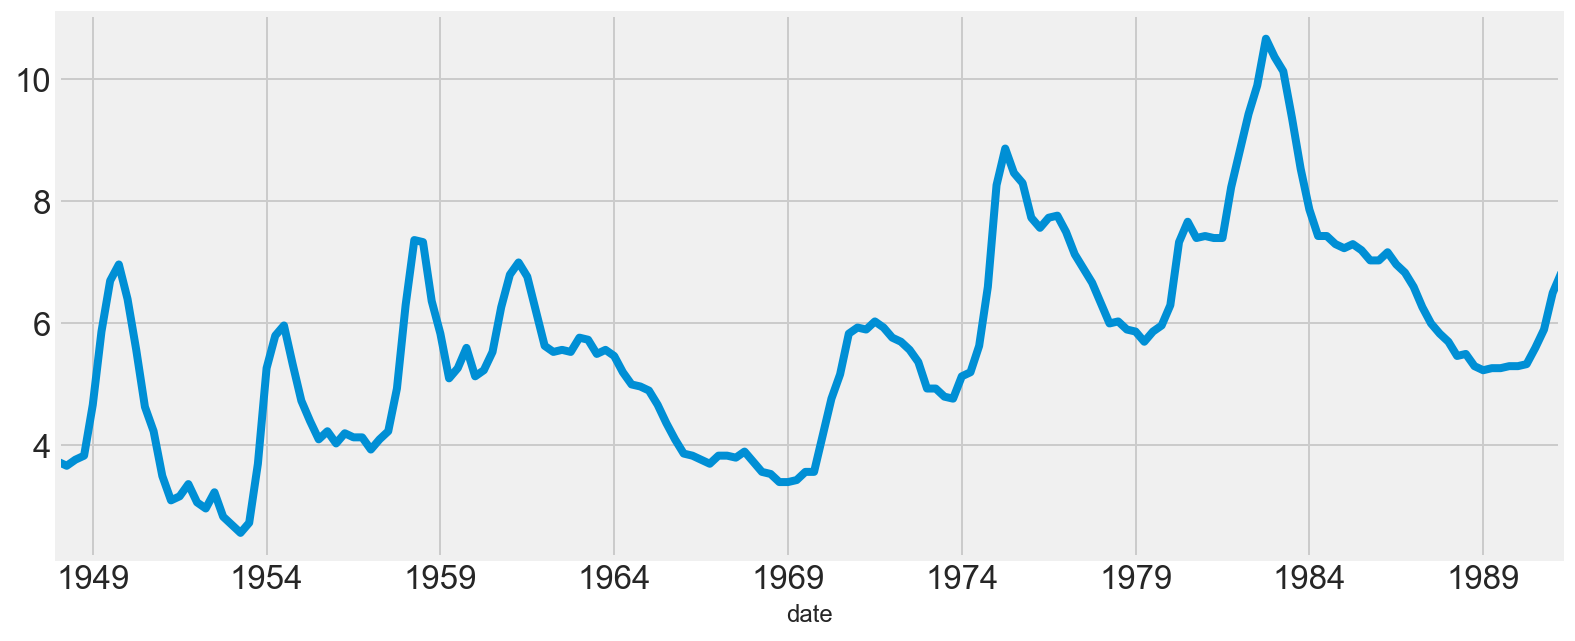

In [10]:
data['unemployment_rate'].plot(lw=4, figsize=(12, 5))
plt.show()

In [11]:
# let's keep that as a variable for later
urate = data.unemployment_rate
udiff = urate.diff()[1:]

## Time series models


What we would like to do in time series modeling is to predict future values in the time series from the preceding ones, e.g.

- the price of an asset tomorrow given the price today
- tomorrow's weather given today's weather and last week's and last year's at the same date

We will have to formulate something like

$$
y_t = f(y_{t-1},y_{t-2},\ldots,y_{1},y_{0}) + \epsilon_t
$$

The task is to find the appropriate function defining our model. As usual, we will have some irreducible error limiting the quality of our predictions.

## ARMA and ARIMA models

**ARMA** models are essentially regression models. To predict the value $y_t$ of the time series at time $t$, we use: 
- the preceding observations $y_{t-1}, y_{t-2}, \ldots, y_{t-p}$ up to $p$ previous time steps. This is called the **Autoregressive (AR)** component of the model. 
- the preceding noise terms $\epsilon_{t-1}, \epsilon_{t-2}, \ldots, \epsilon_{t-q}$ up to q previous time steps. This is called the **Moving Average (MA)** component of the model. 

In this way we base our predictions on previous observations, and we also prescribe a way to predict how being wrong about the last predictions should influence our future predictions.

<font color = red>
**
So we're 'dumbly' taking the past values to predict the future in AR component, but by including the error terms we have a MA component that points to a trend... ie, we incorporate directionality
**
</font>

In total, our model will have $p+q$ parameters and can be formulated like this:

$$
\begin{eqnarray*}
y_t &=& \phi_0 + \phi_1  y_{t-1}\ +\ ...\ +\ \phi_p  y_{t-p}\ + \theta_{1} \epsilon_{t-1} + ... +\theta_{q} \epsilon_{t-n} +\ \epsilon_t \\
y_t &=& \phi_0+\sum_{j=1}^p \phi_j y_{t-j} + \sum_{i=1}^q \theta_i \epsilon_{t-i} + \epsilon_t
\end{eqnarray*}
$$

where 

$$\phi_0=\left(1-\sum_{j=1}^p \phi_j\right)\mu$$

Here $\mu$ is the mean of the time series, and $\epsilon_t$ are uncorrelated noise terms stemming from the same normal distribution with mean zero and the same standard deviation.

For the ARMA model to work properly, the time series is required to be stationary. If initially it is not stationary, it may be made stationary (to sufficient degree) by suitable transformations and differencing.

The Auto Regressive Integrated Moving Average Model (**ARIMA**)
is basically the same as an 
`ARMA(p, q)` model, but we additionally indicate how many differencing steps we carried out, i.e. we just plug in our initial unemployment rate time series, and then indicate that we want to have it differenced $d$ times ($d=1$ in our case) before fitting an `ARMA(p,q)` model to it.

We denote this as an `ARIMA(p,d,q)` model.

Whereas fitting the AR part is straightforward, fitting the MA part is a bit more tricky because the error terms are unobserved. There are a variety of different ways you can estimate the parameters, some of which are covered in this [paper.](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf)

In the simpler fitting procedures, a model is iteratively fit, errors are computed, then refit, over and over again until the parameters of the errors converge.


## Fitting ARIMA models


Fitting ARIMA models is very simple. Just pass the argument `order=(p,d,q)` to indicate the order of the ARIMA model. Alternatively you could fit an ARMA model on the differenced time series. There is a separate function for pure AR models. 

See the [statsmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html).

In [12]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

In [13]:
model = ARIMA(urate, order=(4, 1, 2)).fit(trend='c', maxiter=5000)
# nc stands for having no constant trend
# alternative (default) is c for constant
# including a constant gives a convergence warning

# use summary2 to produce the model output. This version fixes bugs from the summary function.
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: ARIMA
==========================================================================
Model:               ARIMA                BIC:                  131.4621  
Dependent Variable:  D.unemployment_rate  Log-Likelihood:       -45.118   
Date:                2020-02-13 09:48     Scale:                1.0000    
No. Observations:    173                  Method:               css-mle   
Df Model:            7                    Sample:               06-30-1948
Df Residuals:        166                                        06-30-1991
Converged:           1.0000               S.D. of innovations:  0.311     
No. Iterations:      88.0000              HQIC:                 116.470   
AIC:                 106.2357                                             
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                      0.0184   0.0061   3.0158 0.0030  0.0065  0.0304
ar.L1.D.unemployment_rate  0.7433   0.0841   8.8410 0.0000  0.5786  0.9081
ar.L2.D.unemployment_rate  0.6625   0.1082   6.1226 0.0000  0.4504  0.8745
ar.L3.D.unemployment_rate -0.6487   0.0978  -6.6347 0.0000 -0.8404 -0.4571
ar.L4.D.unemployment_rate  0.1027   0.0782   1.3135 0.1908 -0.0505  0.2560
ma.L1.D.unemployment_rate -0.0359   0.0398  -0.9021 0.3683 -0.1138  0.0421
ma.L2.D.unemployment_rate -0.9641   0.0395 -24.4064 0.0000 -1.0415 -0.8867
-------------------------------------------------------------------------------------
                   Real             Imaginary            Modulus            Frequency
-------------------------------------------------------------------------------------
AR.1             -1.1006              -0.0000             1.1006              -0.5000
AR.2              1.3504              -0.2283             1.3695              -0.0267
AR.3              1.3504               0.2283             1.3695               0.0267
AR.4              4.7167              -0.0000             4.7167              -0.0000
MA.1              1.0000               0.0000             1.0000               0.0000
MA.2             -1.0372               0.0000             1.0372               0.5000
==========================================================================

"""

## How to choose the right `p` and `q` parameters
---
<a id="how-to-choose-the-right-p-and-q-parameters"></a>

In general it is never a bad idea to choose your parameters based on hold-out testing. That is to say, checking the performance of your model on future time points based on different choices of `p` and `q` for an ARIMA model.

However, you can get a sense for what parameters will work best based on the autocorrelation and partial autocorrelation plots.

[This site](https://people.duke.edu/~rnau/411arim3.htm) has a very detailed overview of how to use the acf and pacf to determine your parameters.

Below are some basic guidelines which are applicable once your time series is stationary, i.e. you might have to carry out transformations and/or differencing steps before.

After having obtained the stationary time series, inspect the autocorrelation and partial autocorrelation plots.

- Check the autocorrelations.
- If all autocorrelations with a lag larger than q vanish, choose MA(q).
- If there are autocorrelations at all lags (even if maybe very small), check for the partial autocorrelations.
- If the partial autocorrelations for lags larger than p vanish, choose AR(p).
- If both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to the AR or MA alone.

### Model tuning


Now we can build complex models. We need to tune three values in the ARIMA model:
- AR(p) 
- MA(q)
- differencing (d)

- p indicates how many prior time periods are taken into consideration for explained autocorrelation. Increasing p would increase the dependency on previous values further (longer lag).
- q indicates how many prior time periods we are considering for observing sudden trend changes.
- d indicates what difference we are anticipating to predict. We pick d in such a way that we produce a stationary time series (if we can).

**The best model is usually found automatically**

- Selection criteria are AIC or BIC (lowest value for given p, q)
 - [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) stands for Akaike information criterion
 - [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) stands for Bayesian information criterion
- Both are based on the maximum log-likelihood and the number of features 
- AIC and BIC are relative measures of information gain from our model
- AIC and BIC cannot tell us quality in an absolute sense, it's only to be compared for diff models.
- Parsimonious models are the goal — as few features as possible 

$$
\begin{eqnarray*}
{\rm AIC} &=& 2k - 2\log \hat{L}  \\
{\rm BIC} &=& \ln(n) k - 2\log \hat{L} 
\end{eqnarray*}
$$

Here we use

- $k$: number of estimated parameters, no. model parameters
- $\hat{L}$: the maximum value of the likelihood function
- $n$: number of observations

<font color = red>
Ideally we want small as possible for both models, so we know how generalisable the model is, so we choose k and calculate L at each k, then calc the AIC or BIC to see how many k's is optimal (See below)


### Automatic selection of ARMA model based on AIC or BIC

{'aic':             0           1           2           3
0         NaN  129.705486  116.158097  107.424761
1  119.185881  114.075148  114.352832  109.395480
2  110.700738  105.147875  106.506476   96.994629
3  108.172739  106.085194  105.463817  107.379607
4  107.043354  108.919695  107.257155   97.360665, 'bic':             0           1           2           3
0         NaN  136.012070  125.617971  120.037928
1  125.492464  123.535023  126.965998  125.161938
2  120.160612  117.761042  122.272934  115.914379
3  120.785905  121.851652  124.383567  129.452648
4  122.809812  127.839444  129.330196  122.586998, 'aic_min_order': (2, 3), 'bic_min_order': (2, 3)}


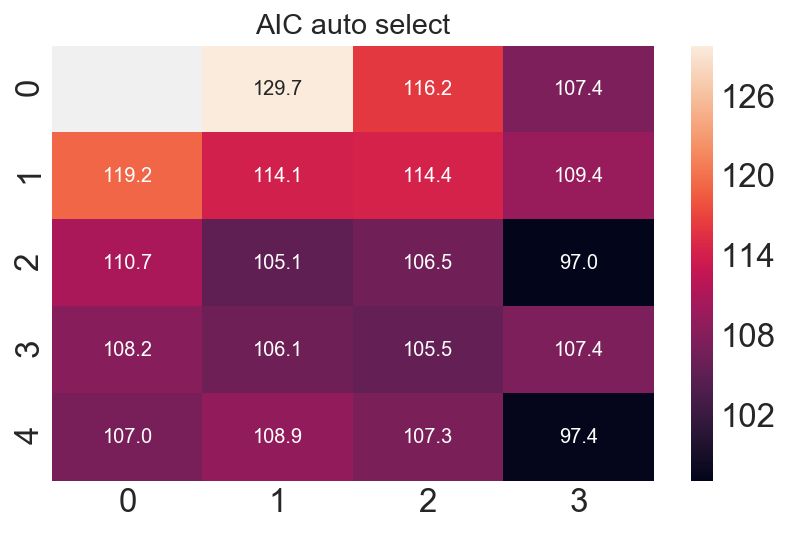

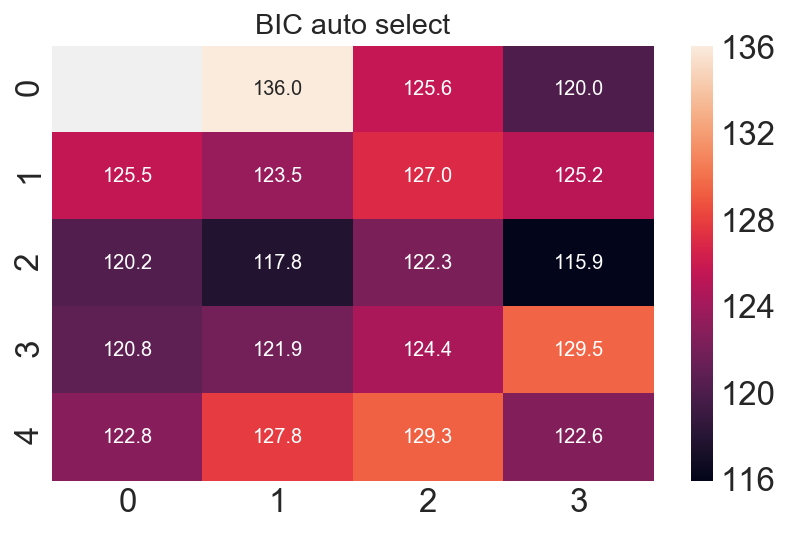

In [14]:
from statsmodels.tsa import stattools

auto_select = stattools.arma_order_select_ic(
    urate.diff()[1:], max_ar=4, max_ma=3, ic=['aic', 'bic'], trend='nc') # feed the diff always to fight
# stationarity, whereas ARIMA did it automatically within the function.

print(auto_select)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.ylim([auto_select['aic'].shape[1]+1, 0])
plt.title('AIC auto select')
plt.show()

sns.heatmap(auto_select['bic'], annot=True, fmt='.1f')
plt.ylim([auto_select['bic'].shape[1]+1, 0])
plt.title('BIC auto select')
plt.show()

### Let's fit our best model according to AIC, ARMA(2,3)

In [15]:
model = ARMA(udiff, order=(2, 3))
result = model.fit(start_params=[0, 0, 0, 0, 0],
                   solver='lbfgs', method='css', trend='nc', ic='BIC')
# without setting start_params it might not succeed in finding the MLE
# requires as many start_params as model parameters, i.e. p+q
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: ARMA
=======================================================================
Model:                ARMA              BIC:                 114.6968  
Dependent Variable:   unemployment_rate Log-Likelihood:      -41.923   
Date:                 2020-02-13 09:49  Scale:               1.0000    
No. Observations:     173               Method:              css       
Df Model:             5                 Sample:              12-31-1948
Df Residuals:         166                                    06-30-1991
Converged:            1.0000            S.D. of innovations: 0.309     
No. Iterations:       25.0000           HQIC:                103.495   
AIC:                  95.8468                                          
-----------------------------------------------------------------------
                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
ar.L1.unemployment_rate  0.1261   0.1087  1.1595 0.2479 -0.0870  0.3391
ar.L2.unemployment_rate -0.4811   0.0920 -5.2291 0.0000 -0.6614 -0.3008
ma.L1.unemployment_rate  0.5977   0.1023  5.8428 0.0000  0.3972  0.7982
ma.L2.unemployment_rate  0.9066   0.0449 20.1720 0.0000  0.8185  0.9947
ma.L3.unemployment_rate  0.5694   0.0790  7.2043 0.0000  0.4145  0.7243
---------------------------------------------------------------------------------
                  Real            Imaginary           Modulus           Frequency
---------------------------------------------------------------------------------
AR.1             0.1310             -1.4358            1.4418             -0.2355
AR.2             0.1310              1.4358            1.4418              0.2355
MA.1             0.0116             -1.0426            1.0427             -0.2482
MA.2             0.0116              1.0426            1.0427              0.2482
MA.3            -1.6154             -0.0000            1.6154             -0.5000
=======================================================================

"""

### Forecast for this model

We distinguish different ways of forecasting.

- In-sample forecasts:
 - We predict one-step ahead using the true values up to that point (non-dynamic forecasting).
 - We use the first few values in the time series to predict the next ones, and the ones further in the future using the predicted values as input (dynamic forecasting).
- Out-of-sample forecasts:
 - We predict further into the future using predicted values as input.
 - If we predict for a long time into the future, our forecast will be (very close to) the mean.
 - It is important to indicate confidence intervals for our forecast. We can never be sure about the future, but we can be reasonably sure that future values will stay within certain bounds.
 - The width of the confidence interval becomes constant. This is due to stationarity. For a non-stationary time series, the confidence interval would become wider and wider.

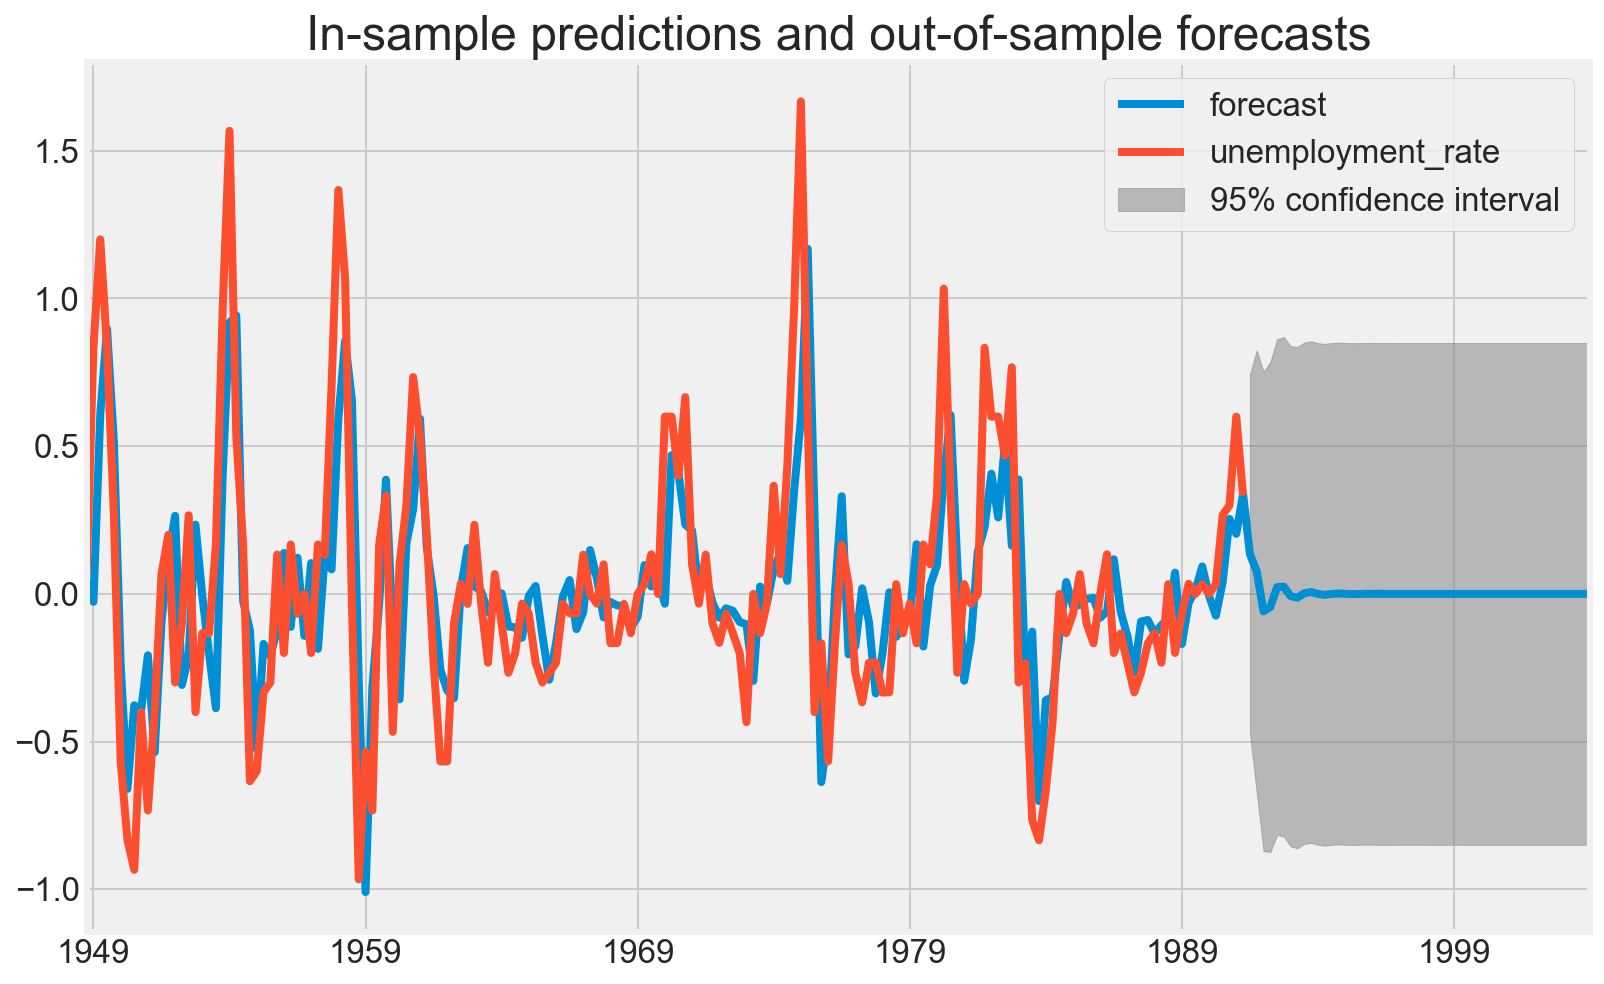

In [16]:
init_1 = 2
end_1 = len(udiff)+50
fig, ax = plt.subplots(figsize=(12, 8))
result.plot_predict(init_1, end_1, dynamic=False, plot_insample=True, ax=ax)
ax.set_title('In-sample predictions and out-of-sample forecasts', fontsize=24)
plt.show()

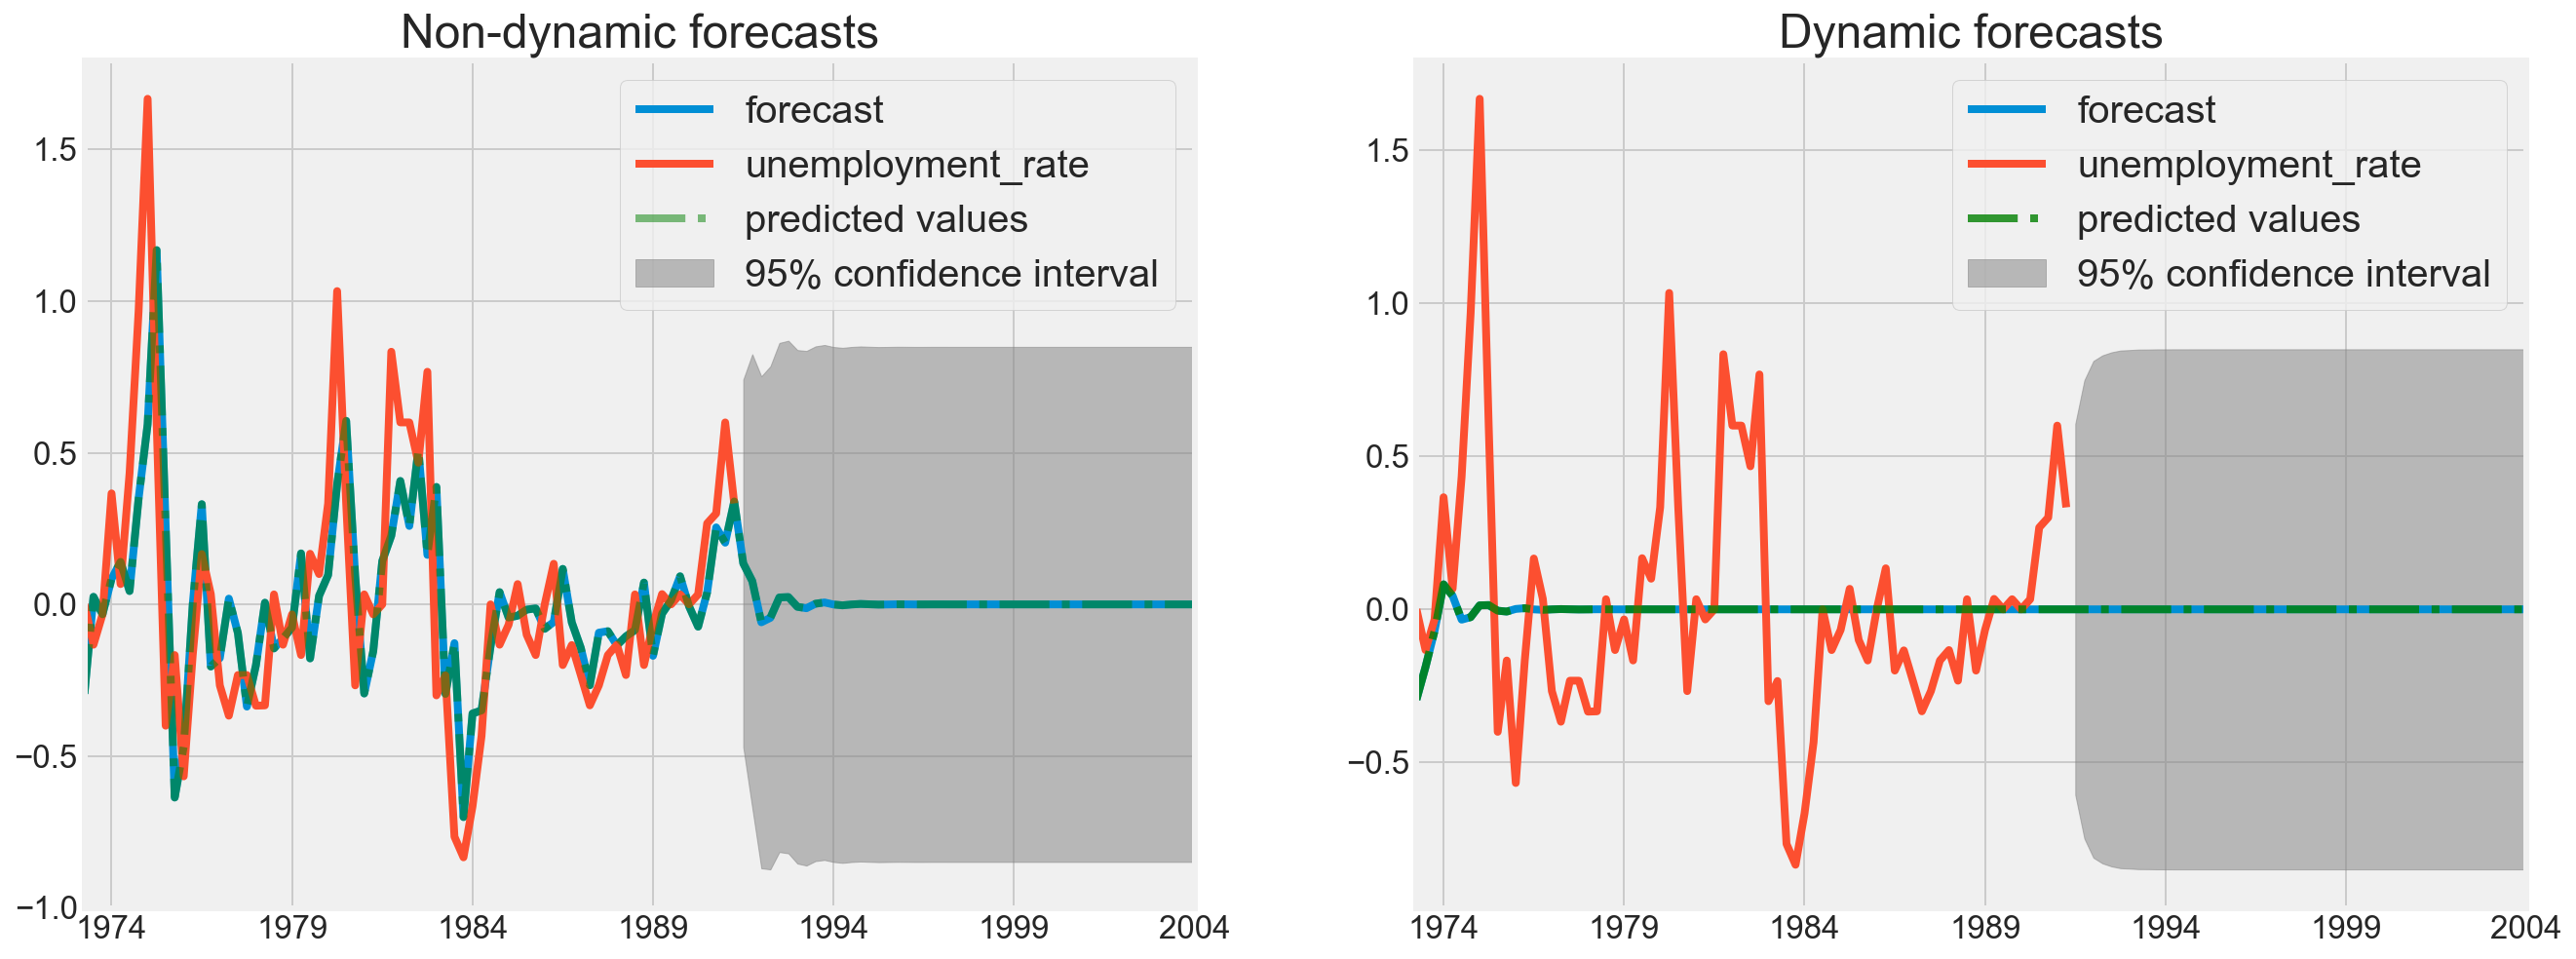

In [17]:
# starting and end points for forecasting
init_1 = 100
end_1 = len(udiff)+50

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

# ax[0]
result.plot_predict(init_1, end_1, dynamic=False, plot_insample=True, ax=ax[0])

# The following line is added to the plot just to show
# how to obtain the same values
result.predict(start=init_1, end=end_1, dynamic=False).plot(
    ax=ax[0], color='green', ls='-.', lw=4, alpha=0.5, label='predicted values')

ax[0].set_title('Non-dynamic forecasts', fontsize=24)
ax[0].legend(fontsize=20)

# ax[1]
result.plot_predict(init_1, end_1, dynamic=True, plot_insample=True, ax=ax[1])

# The following line is added to the plot just to show
# how to obtain the same values
result.predict(start=init_1, end=end_1, dynamic=True).plot(
    ax=ax[1], color='green', ls='-.', lw=4, alpha=0.8, label='predicted values')

ax[1].set_title('Dynamic forecasts', fontsize=24)
ax[1].legend(fontsize=20)

plt.show()

### Scores

We can use our usual scores to compare true and predicted values. Some of the required information is contained in our fitted model object.

- `fittedvalues` contains the one-step ahead forecasts.
- `sigma2` contains the MSE resulting from comparing true values and one-step ahead forecasts.

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
print('MSE sklearn:\t\t', mean_squared_error(
    udiff[2:], result.fittedvalues[:])) # start from 2nd item due to the AR[2] order which requires two obs to 
# be calculated
print('MSE statsmodels:\t', result.sigma2)

MSE sklearn:		 0.09560361234383347
MSE statsmodels:	 0.09560361234383342


In [20]:
# compare to baseline predicting the mean - we can see that MSE above was half this MSE here
mean_squared_error(udiff, [udiff.mean()] * len(udiff))

0.18995638651475158

In [28]:
# compare to predicting always the last value - which would be a better baseline.
# ie. did our model outperform the simplest version of our model
mean_squared_error(udiff[1:], udiff.shift(1)[1:])

0.13954708720930228

### Residuals

As in linear regression, we can judge the quality of our model by looking at our residuals. We would like that

- there are no trends in the size of the residuals
 - plot the values of the residuals, but we see below there is some trend in time, which isn't what we like
- the residuals are uncorrelated
 - plot the autocorrelations of the residuals (correlogram)
- the residuals are normally distributed 
 - compare to the standard normal distribution through quantile-quantile plot and histogram

In [22]:
from scipy import stats
import statsmodels.api as sm


def residual_plot(res):
    resid_standard = (res - res.mean()) / res.std()

    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

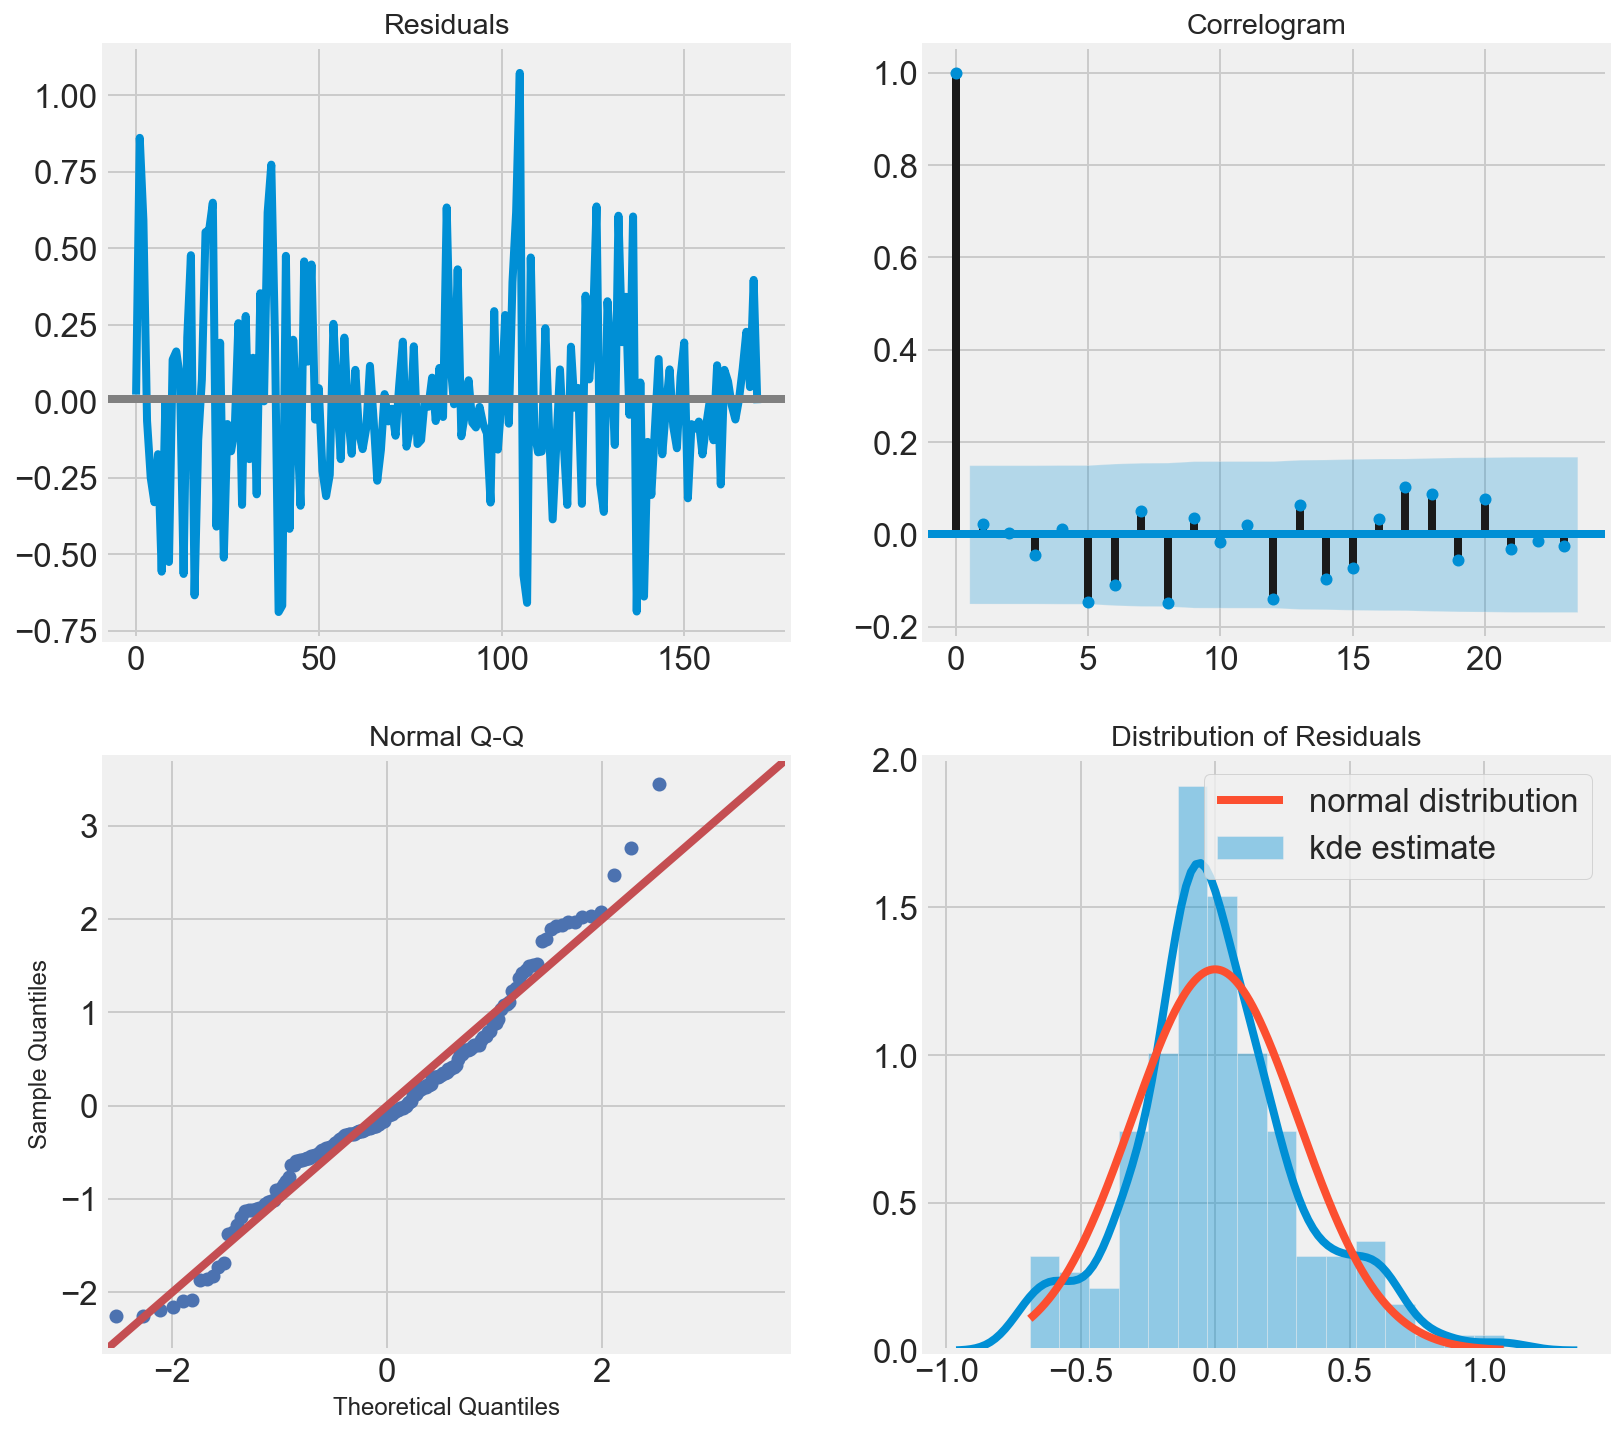

In [23]:
residual_plot(result.resid.values)

### Cross validation on different time series splits

In [24]:
from sklearn.model_selection import TimeSeriesSplit

In [25]:
ts = TimeSeriesSplit(n_splits=3)
splits = [split for split in ts.split(udiff)]

In [26]:
udiff.iloc[splits[0][0]].head(10)

date
1948Q2   -0.066
1948Q3    0.100
1948Q4    0.066
1949Q1    0.834
1949Q2    1.200
1949Q3    0.833
1949Q4    0.267
1950Q1   -0.567
1950Q2   -0.833
1950Q3   -0.934
Freq: Q-DEC, Name: unemployment_rate, dtype: float64

In [34]:
mses = []
for i in range(ts.n_splits):
    y_train = udiff.iloc[splits[i][0]]
    y_test = udiff.iloc[splits[i][1]]

    model_cv = ARMA(y_train, order=(2, 3))
    result_cv = model_cv.fit(start_params=np.zeros(model_cv.k_ar+model_cv.k_ma),
                       solver='lbfgs', method='css', trend='nc')
    predictions_test = result_cv.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
    mses.append(((y_test.subtract(predictions_test))**2).mean())

print(mses)
print(np.mean(mses))

# you could update the order parameters through a for-loop (which we will do below) and search for one which 
# gives you best mse

[0.07781069324434152, 0.19988451577811853, 0.12622920826369413]
0.13464147242871805


#### Exercise: Run cross validation on a variety of ARMA models to determine the best order.

- Average the MSEs obtained from the cross validation for each model.
- Take care of the fact that some order combinations could fail (try-except could be useful).
- Compare to the results obtained with AIC. Do they agree?

In [35]:
# Look at the solution... I don't get this

## Summary of time series modeling

- Visualize the time series
- Make the time series stationary - ie. differencing
 - Is there a clear trend in the data? if so try diff().diff()
 - Are there periodic patterns / seasonal effects?
- Plot ACF/PACF to seek optimal parameters
- Build the ARIMA model
    - Evaluate the model with AIC or BIC 
- Predict the future
    - Obtain in-sample and out-of-sample forecasts
    - Evaluate model scores

## Model Limitations

- We made assumptions about stationarity
- Trends can be removed by transformation and/or differencing
- Long term patterns in the correlations can be taken into account by Seasonal ARIMA models (another lesson)
- Time dependent variances of the error term can be taken into account by GARCH models
- There are many more specialized models

## Additional Resources

- [Blackarbs - Time series analysis in python - linear models to garch](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)
- [Quantstart - time series analysis](https://www.quantstart.com/articles#time-series-analysis)
- [Digital Ocean - A guide to time series forecasting](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
- [Harvard lectures](http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-17.html)
- [Statsmodels ARMA Example](http://www.statsmodels.org/devel/examples/notebooks/generated/tsa_arma_0.html)